 # Prediction of FRONTEX illegal border crossings using GTI in a LSTM model
 
 ## Contents:
* 1. [Preparation](#1)
   * 1.1. [GTI and IBC data](#1.1)
       * 1.2.1. [Google Trends Index data](#1.1.1)
       * 1.2.2. [Illegal Border Crossings data](#1.1.2)
   * 1.2. [Merged data](#1.2)
* 2. [LSTM model](#2)
   * 2.1. [Model Geometry](#2.1)
   * 2.2. [Loss functions](#2.2)
   * 2.3. [Model evaluation](#2.3)
   * 2.4. [Model Visualization](#2.4)
* 3. [Results](#3)
   * 3.1. [Baseline model](#3.1)
       * 3.1.1. [Without Google Trend Indices](#3.1.1)
       * 3.1.2. [With Google Trend Indices](#3.1.2)
   * 3.2. [Results with GTI](#3.2)
   * 3.3. [Hyperparameter search](#3.3)

In [1]:
import keras.backend as kb
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow import keras
from keras.regularizers import L1L2
from keras.optimizers import Adam
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.colors import SymLogNorm
import sys 

location_data='C:\\Users\\adema\\Documents\\ifo\\ifo\\Coursework\\ML\\Term Paper Project\\'

 # 1. Preparation <a id="1">

 ## 1.1 GTI and IBC data <a id="1.1">
    
    In this section, we import the data that have been queried in run_gtitan_create.ipynb and we briefly plot it. For more details about the sourcing, see there and the report. 
    First, we consider one of the Trends series over time, namely that of the keyword "migration" in Syria from 2004 to 2021. Note that the GTI index is noisier in earlier time periods, likely because of lower sampling rates of search traffic and a lower total volume of the internet traffic. We observe multiple peaks in the summer months of 2013,2014,2015, indicating a higher relative interest in "migration", compared to other search patterns. This interest flattens after 2016.
    
    Second, we will consider the Frontex data in terms of the monthly illegal border crossings towards Europe between January 2009 and November 2020, summing over all countries of origin and routes. We clearly observe the strong peak around the midst of the migrant crisis in 2015.

  ### 1.1.1 Google Trends Index data <a id="1.1.1">

Text(0, 0.5, 'GT Index [Normalized]')

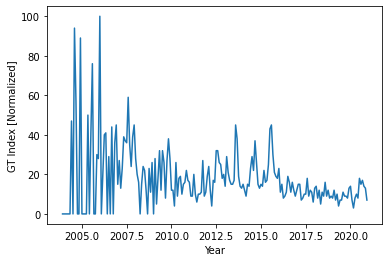

In [2]:
gti_df = pd.read_csv(location_data+'Data\\timeframe.csv')
a = gti_df[gti_df['geo']=='SY']['migration']
plt.plot(a.index/12+791,a.values)
plt.xlabel('Year')
plt.ylabel('GT Index [Normalized]')

   ### 1.1.2 Illegal Border Crossings data <a id="1.1.2">

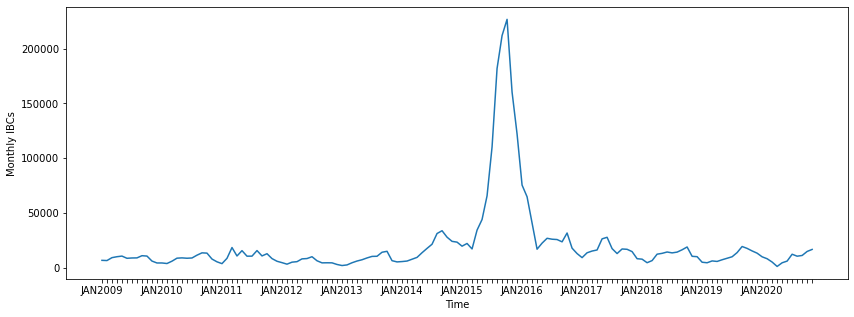

In [3]:
flow_df = pd.read_csv(location_data+'Data\\raw_migration_flows.csv')
y = flow_df.sum()[1:]
x = flow_df.columns[1:]
import sys
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14,5))
plt.plot(x,y)
every_nth = 12
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.xlabel('Time')
plt.ylabel('Monthly IBCs')
plt.savefig('Flow_data.png')

 ## 1.2 Merged data <a id="1.2">
    
    Here we source the data, apply the minmax scaler to the data where necessary and make into list
    We put out two different dataframes:  lstm_df_base without GTI and lstm_df_gti with GTI

In [6]:
lstm_df = pd.read_pickle(location_data+'Data\\lstm_df.pkl')

def extractList(lst): 
    return list(map(lambda el:[el], lst))                                                
def listMaker(row):
    return extractList(row['mig_flow'])
lstm_df['mig_flow'] = lstm_df.apply(listMaker, axis=1)

#Scale the data on a min-max basis: (OVER ALL features!) TOCHECK
lstm_df['GTI'] = lstm_df['GTI'].apply(np.array).T.apply(MinMaxScaler(feature_range=(0, 1)).fit_transform).apply(np.ndarray.tolist)
lstm_df['Country FE'] = lstm_df['Country FE'].apply(np.array).T.apply(MinMaxScaler(feature_range=(0, 1)).fit_transform).apply(np.ndarray.tolist)
lstm_df['mig_flow_norm'] = lstm_df['mig_flow'].apply(MinMaxScaler(feature_range=(0, 1)).fit_transform).apply(list)
lstm_df['GTI'] = lstm_df['GTI'].tolist()
lstm_df['Country FE'] = lstm_df['Country FE'].tolist()

#Function to parse rows in list for later use
def makeTRows(row):
    row['X']=list(map(list, zip(*row['X'])))

#Add all desired covariates in a column X
lstm_df_base = lstm_df
lstm_df_base['X'] = lstm_df_base['Country FE']+lstm_df_base['Route FE']+lstm_df_base['Time FE']#+lstm_df['GTI']
x_transpose=pd.DataFrame()
x_transpose['X']=lstm_df_base['X']
x_transpose.apply(makeTRows,axis=1)
lstm_df_base['X']=x_transpose['X']

#Add all desired covariates in a column X, including the GTI
lstm_df_gti = lstm_df
lstm_df_gti['X'] = lstm_df_gti['Country FE']+lstm_df_gti['Route FE']+lstm_df_gti['Time FE']+lstm_df_gti['GTI']
x_transpose=pd.DataFrame()
x_transpose['X']=lstm_df_gti['X']
x_transpose.apply(makeTRows,axis=1)
lstm_df_gti['X']=x_transpose['X']

#Show first entry of the combined data set
lstm_df_gti.reset_index().head(1)


,index,Route,Nationality,ISO2,Country_route_ID,mig_flow,time,index_l,arrival_l,emigrant_l,...,waiver_l,GTI,Country FE,Route FE,Country-Route FE,Time FE,mig_flow_L12,mig_flow_L1,mig_flow_norm,X
0,0,Black Sea Route,Afghanistan,AF,0,"[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...","[2009-01-01T00:00:00.000000000, 2009-02-01T00:...","[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 7...","[0, 0, 0, 0, 38, 0, 37, 0, 0, 36, 73, 0, 0, 39...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[83, 0, 0, 0, 0, 0, 58, 0, 0, 0, 0, 0, 54, 63,...","[[0.7228915662650602, 1.0, 1.0, 0.63, 0.888888...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


 # 2. LSTM <a id="2">

 ## 2.1 Loss functions <a id="2.1">

    We define two models, one with and one without L1 weight regularization

In [7]:
# Common Part of Commuters 
def cpc(y_true, y_pred):
    return (2.0 * kb.sum(kb.minimum(y_true, y_pred))) / (kb.sum(y_true) + kb.sum(y_pred))
# Common Part of Commuters loss function
def cpc_loss(y_true, y_pred):
    return 1.0 - cpc(y_true, y_pred)

loss = [cpc_loss, 'mse'] # to be passed to model.compile(), loss parameter
custom_metrics = [cpc, 'mse'] # to be passed to model.compile(), metrics parameter

## 2.2 Model Geometry <a id="2.2">

In [8]:
def lstmModel(data, loss = cpc_loss, size_hidden_layer = 50, dropout = 0.0):
    '''
    data              : a dataframe like the transformData return
    l                 : loss function to build model
    size_hidden_layer : size of the LSTM's hidden layer
    dropout           : value of the model's dropout
    returns           : the defined model
    '''
    n_features = len(data['X'][0][0]) 
    model = Sequential()
    if dropout > 0.0:
        model.add(Dropout(dropout, input_shape=(1, n_features)))
    model.add(LSTM(size_hidden_layer, activation='relu', input_shape=(1, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss=loss, metrics = custom_metrics)
    return model
def lstmModelReg(data, loss = cpc_loss, size_hidden_layer = 50, dropout = 0.0):
    '''
    data              : a dataframe like the transformData return
    l                 : loss function to build model
    size_hidden_layer : size of the LSTM's hidden layer
    dropout           : value of the model's dropout
    returns           : the defined model
    '''
    n_features = len(data['X'][0][0]) 
    model = Sequential()
    if dropout > 0.0:
        model.add(Dropout(dropout, input_shape=(1, n_features)))
    model.add(LSTM(size_hidden_layer, recurrent_regularizer=L1L2(l1=0.001, l2=0.0), activation='relu', input_shape=(1, n_features)))
    model.add(Dense(1))
    model.compile(optimizer=Adam(lr=0.0005), loss=loss, metrics = custom_metrics)
    return model

## 2.3 Model evaluation <a id="2.3">

In [9]:
def train_evaluate(model, data, verbose = 1, epoch = 1, test_month = np.datetime64('2020-11-01'), normBySerie = True, use_log = False, normInTotal = False, evaluate_freq = 1):
    '''
    model         : lstm (keras model)
    data          : a dataframe like the transformData return
    verbose       : should I show epoch (0 shut up) 
    epoch         : number of epoch
    test_year     : the year used as test set
    normBySerie   : indicates for the evaluation if @data was normed by serie origin-destination
    use_log       : indicates for the evaluation if the log values was used in @data
    normInTotal   : indicates for the evaluation if @data was normed for all series origin-destination
    evaluate_freq : the model is evaluated every @evaluate_freq epochs
    returns       : the history of the different metrics for every evaluation done
    '''
    def trainModel(row):
        X, y = row['X'], row['mig_flow_norm'] # I take a series that is a pair origin-destination spanning from 2004-2014 (some missing years maybe)
        if test_month in row['time']: # Remove the test year from the train
            X, y = row['X'][:-1], row['mig_flow_norm'][:-1]
        if len(X) != 0:
            y=np.array(y)
            X = np.array(X).reshape((len(X),1,len(X[0]))) # batch size, years I take, # of feats
            model.fit(X, y, epochs = 1, verbose = 0, shuffle = False) # loss, metrics for the train

    history = [] # for train and test metrics at every epoch
    for j in range(epoch): # repeat the traning on the whole data epoch times
        data.apply(trainModel,axis=1)
        if j%evaluate_freq == 0: #evaluation on all the different metrics
            dataResult = evaluateBySerie(model, data, normBySerie = normBySerie, use_log = use_log, normInTotal = normInTotal)
            train_metrics, test_metrics, total_train_metrics, total_test_metrics = totalEvaluation(dataResult, display = False, test_month = test_month)
            history.append(total_train_metrics + total_test_metrics )
            print('EPOCH :', j + 1)
            if verbose > 0:
                print('train rmse : ' + str(total_train_metrics[0]) + ' - train cpc : ' + str(total_train_metrics[1]))
                print('test rmse : ' + str(total_test_metrics[0]) + ' - test cpc : ' + str(total_test_metrics[1]))
    return list(map(list,zip(*history)))


In [10]:
# Calculate CPC as a numpy array
def CPC(y,y_pred):
    return 2 * np.sum(np.minimum(y,y_pred))/(np.sum(y)+np.sum(y_pred))

def calculate_metrics(y,y_pred):
    rmse = np.sqrt(metrics.mean_squared_error(y,y_pred))
    Cpc = CPC(y,y_pred)
    return [rmse,Cpc]

def evaluateBySerie(model, newData, normBySerie = True, use_log = False, normInTotal = False):
    tot_mig = np.array([el for serie in list(newData['mig_flow']) for el in serie])
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(tot_mig)
    def evaluateRow(row):
        X, y, y_real = row['X'], row['mig_flow_norm'], row['mig_flow']
        X = np.array(X).reshape((len(X), 1, len(X[0])))
        y_pred = model.predict(X,verbose=0)
        y_real_pred = y_pred
        if normBySerie:
            scalerSerie = MinMaxScaler(feature_range=(0, 1)).fit(y_real)
            y_real_pred = scalerSerie.inverse_transform(y_pred)
        elif use_log:
            y_real_pred = np.exp(y_pred)-1
        elif normInTotal:
            y_real_pred = scaler.inverse_transform(y_pred)
        y=np.array(y)
        y_real=np.array(y_real)
        y = y.flatten()
        y_pred = y_pred.flatten()
        y_real_pred = y_real_pred.flatten()
        y_diff = np.subtract(y_real_pred.flatten(), y_real.flatten())
        res = [y_pred,y_real_pred,y_diff] + calculate_metrics(y,y_pred) + calculate_metrics(y_real,y_real_pred)
        return res
    res = np.array(newData.apply(evaluateRow,axis=1).to_list())
    newDF =  pd.DataFrame(res, columns=['y_pred', 'y_real_pred', 'y_diff', 'rmse', 'cpc', 'rmse_total', 'cpc_total'], index=newData.index)
    return pd.concat([newData,newDF], axis=1)

# Evaluate the LSTM model by calculating for the complete data the metrics rmse and cpc
# Here, train_metrics and test_metrics refer to the minmaxscaler-normalized set, 
# whereas total_train_metrics and total_test_metrics       : the normalized test set

def totalEvaluation(data,test_month = np.datetime64('2020-11-01'),display=True):
    def separate(row):
        if test_month in row['time']:
            return [row['mig_flow_norm'][:-1],[row['mig_flow_norm'][-1]],row['y_pred'][:-1],[row['y_pred'][-1]],row['mig_flow'][:-1],[row['mig_flow'][-1]],row['y_real_pred'][:-1],[row['y_real_pred'][-1]]]
        else:
            return [row['mig_flow_norm'],[],row['y_pred'],[],row['mig_flow'],[],row['y_real_pred'],[]]
    def flatten(l):
        return [[x for serie in set for x in serie] for set in l]
    allData = data.apply(separate,axis=1)
    allData = list(map(list,zip(*allData)))
    [y_train,y_test,y_train_pred,y_test_pred,y_real_train,y_real_test,y_real_train_pred,y_real_test_pred] = flatten(allData)
    if display:
        y_real = np.array(y_real_train + y_real_test)
        y_pred = np.array(y_real_train_pred + y_real_test_pred)
        scatter_plot(np.array(y_real_test),np.array(y_real_test_pred),'scatter_LSTM.svg')
    y_real_train = np.array(y_real_train).reshape((len(y_real_train)))
    y_train = np.array(y_train).reshape((len(y_train)))
    y_real_test = np.array(y_real_test).reshape((len(y_real_test)))
    y_test = np.array(y_test).reshape((len(y_test)))
    train_metrics = calculate_metrics(y_train, y_train_pred)
    test_metrics = calculate_metrics(y_test, y_test_pred)
    total_train_metrics = calculate_metrics(y_real_train, y_real_train_pred)
    total_test_metrics = calculate_metrics(y_real_test, y_real_test_pred)
    return train_metrics, test_metrics, total_train_metrics, total_test_metrics

## 2.4 Model Visualization <a id="2.4">

In [11]:
# Display the training history of the model, the values of the different metrics
# as returned by train_evaluate
#
# @history : of the different metrics by epoch for a given model
def display_training(history, name='default'):
    model_metrics = history
    half = int(len(model_metrics) / 2)
    name_metrics = ['rmse', 'cpc']
    #First half is training, second half is testing:
    train_metrics, val_metrics = model_metrics[:half], model_metrics[half:]
    ratio = 10 # for figure size
    fig, ax = plt.subplots(half, figsize = (1 * ratio, 2 * ratio))
    fig.tight_layout(pad=3.0)
    for i in range(half):
        ax[i].set_title(name_metrics[i] + ' on train and test sets')
        ax[i].plot(train_metrics[i])
        ax[i].plot(val_metrics[i])
        ax[i].set_ylabel(name_metrics[i])
        ax[i].set_xlabel('Number of epochs')
        ax[i].legend(['Train', 'Test'], loc='upper right')
        plt.savefig(name+'.png')

In [12]:
# Draw a scatter plot from the predicted and observed values
def scatter_plot(y_real,y_pred,name=None):
    fig = plt.figure(figsize=(10,10))
    plt.scatter(y_real,y_pred,c='r',alpha=0.5)
    plt.plot(range(0, int(np.max(y_real))),range(0, int(np.max(y_real) )),'g')
    plt.xlabel('Observed values')
    plt.ylabel('Predicted values')
    plt.yscale('log')
    plt.xscale('log') 
    plt.show()
    if name is not None:
        fig.savefig(name)


 # 3. Results <a id="3">
## 3.1 Baseline model  <a id="3.1">
    
    We train the model on data of january 2019 until October 2020. We test the trained model on data of a single month: 
    November 2020
    
### 3.1.1 Without Google Trend Indices <a id="3.1.1">

In [ ]:
data = lstm_df_base
model = lstmModel(data,loss=cpc_loss,size_hidden_layer=70,dropout=0.2)
history_base_now = train_evaluate(model, data, test_month = np.datetime64('2020-11-01'), verbose = 1, epoch = 70)
display_training(history_base_now,name='base_no_weights')
dataResult = evaluateBySerie(model,lstm_df_base)
train_metrics,test_metrics,total_train_metrics,total_test_metrics = totalEvaluation(dataResult)

<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 1
train rmse : 910.45240793138 - train cpc : 0.31557253503818106
test rmse : 762.7170682946669 - test cpc : 0.27714655256867


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 2
train rmse : 865.5602260256718 - train cpc : 0.34003989702017484
test rmse : 641.0440777075069 - test cpc : 0.29670272394022695


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 3
train rmse : 831.2186938460868 - train cpc : 0.355471760240468
test rmse : 584.9278249872531 - test cpc : 0.31341687184143213


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 4
train rmse : 813.0218097782024 - train cpc : 0.3660830047497357
test rmse : 605.4052591576343 - test cpc : 0.3070465733052918


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 5
train rmse : 804.7975283803431 - train cpc : 0.37322491991849144
test rmse : 511.041107696824 - test cpc : 0.3294466655881612


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 6
train rmse : 808.6541588365425 - train cpc : 0.37521290249056916
test rmse : 491.1645129656788 - test cpc : 0.3377088526276707


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 7
train rmse : 812.1046830634785 - train cpc : 0.3784990312578087
test rmse : 506.99977282798216 - test cpc : 0.3322630589132471


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 8
train rmse : 815.1804675113605 - train cpc : 0.37899588440240395
test rmse : 565.9806978781763 - test cpc : 0.3182012848490151


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 9
train rmse : 808.6696816529839 - train cpc : 0.38124636126006817
test rmse : 561.4245244917073 - test cpc : 0.315627946302467


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 10
train rmse : 810.6066826151321 - train cpc : 0.3795493783631413
test rmse : 575.486045317911 - test cpc : 0.315493646656964


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 11
train rmse : 806.231092346148 - train cpc : 0.3850445793605572
test rmse : 494.8274010462094 - test cpc : 0.3253101358496849


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 12
train rmse : 811.0182474863617 - train cpc : 0.3883750619103963
test rmse : 532.7108801638385 - test cpc : 0.32622233554457297


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 13
train rmse : 792.2539590192653 - train cpc : 0.3918688692459252
test rmse : 470.27273643848497 - test cpc : 0.3429010278263782


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 14
train rmse : 811.3105362190737 - train cpc : 0.38525221685181854
test rmse : 553.0601854898854 - test cpc : 0.31947588035176977


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 15
train rmse : 803.1516774018443 - train cpc : 0.39652051508813124
test rmse : 476.65546521657114 - test cpc : 0.32391165387702503


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 16
train rmse : 874.0576873121654 - train cpc : 0.3735828427095938
test rmse : 651.8508500701366 - test cpc : 0.2998690405154599


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 17
train rmse : 846.850233508022 - train cpc : 0.3866190022310964
test rmse : 558.9415048244379 - test cpc : 0.31472116939189393


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 18
train rmse : 778.568688959778 - train cpc : 0.40488458861346965
test rmse : 418.0617241759613 - test cpc : 0.3288741900490463


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 19
train rmse : 822.5257726576301 - train cpc : 0.3939641584692849
test rmse : 522.0796335581008 - test cpc : 0.3349134877223593


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 20
train rmse : 865.0344299104748 - train cpc : 0.3857971764395999
test rmse : 611.7939286967874 - test cpc : 0.29957282273964997


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 21
train rmse : 815.1476302083639 - train cpc : 0.3995509349385294
test rmse : 542.2797168892321 - test cpc : 0.31924834537714747


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 22
train rmse : 834.6418508034786 - train cpc : 0.3952195983391947
test rmse : 502.4005313475012 - test cpc : 0.32276283765228503


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 23
train rmse : 809.1138481947986 - train cpc : 0.4012306931152103
test rmse : 470.2436343463776 - test cpc : 0.3226552408000828


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 24
train rmse : 828.6670930619404 - train cpc : 0.3970422439845557
test rmse : 470.01944739817066 - test cpc : 0.32071357687106516


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 25
train rmse : 795.9969176165403 - train cpc : 0.4040907061166694
test rmse : 448.64088625079125 - test cpc : 0.3219155696041957


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 26
train rmse : 812.4178791794998 - train cpc : 0.4078801306365042
test rmse : 434.53502625417946 - test cpc : 0.32771968121358525


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 27
train rmse : 826.6582589065515 - train cpc : 0.3925713977559376
test rmse : 491.882037692244 - test cpc : 0.3099720946268554


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 28
train rmse : 809.555216052516 - train cpc : 0.40918457761459587
test rmse : 429.8394922371454 - test cpc : 0.3230871733801654


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 29
train rmse : 838.7528080933977 - train cpc : 0.3992648870571291
test rmse : 476.9746761259953 - test cpc : 0.3150972332081517


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 30
train rmse : 815.0487204746547 - train cpc : 0.40985384682368176
test rmse : 458.6746171454017 - test cpc : 0.33652837379585326


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 31
train rmse : 819.8209165261458 - train cpc : 0.40436816993201746
test rmse : 423.0261449438705 - test cpc : 0.3166889539107672


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 32
train rmse : 819.216739974685 - train cpc : 0.4102363028109484
test rmse : 433.74177612816567 - test cpc : 0.3041004795746194


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 33
train rmse : 801.4123652535844 - train cpc : 0.41384241506245834
test rmse : 419.1215533268065 - test cpc : 0.32216304235928156


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 34
train rmse : 797.4268584196286 - train cpc : 0.418921424990782
test rmse : 425.08120078531726 - test cpc : 0.3327194968670219


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 35
train rmse : 822.8726503284921 - train cpc : 0.4061693393869923
test rmse : 475.4065119328804 - test cpc : 0.3295980845649882


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 36
train rmse : 814.1955151782173 - train cpc : 0.41151237541176855
test rmse : 472.3910015022064 - test cpc : 0.3263497347886344


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 37
train rmse : 826.2949011471662 - train cpc : 0.4112227870900277
test rmse : 446.5476708117403 - test cpc : 0.33269806161916254


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 38
train rmse : 848.5726339597205 - train cpc : 0.4028325057700697
test rmse : 459.63215993345545 - test cpc : 0.32764920549707005


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 39
train rmse : 864.5796746248469 - train cpc : 0.40525159141907563
test rmse : 470.621056398924 - test cpc : 0.3172564464217008


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 40
train rmse : 801.4742985042152 - train cpc : 0.4174995193764004
test rmse : 375.33500413230723 - test cpc : 0.324068724976611


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 41
train rmse : 804.2758551123993 - train cpc : 0.41727196606934774
test rmse : 392.08549889155444 - test cpc : 0.3328126357541447


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 42
train rmse : 796.9234997916539 - train cpc : 0.4245776243451873
test rmse : 369.08666646897007 - test cpc : 0.32599267521947256


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 43
train rmse : 825.40583635875 - train cpc : 0.4173127757287322
test rmse : 341.8162874487631 - test cpc : 0.3291020427018359


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 44
train rmse : 812.1338678575875 - train cpc : 0.42083208932119276
test rmse : 408.877354730528 - test cpc : 0.32293755841423716


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 45
train rmse : 827.6682603597058 - train cpc : 0.4223056613577753
test rmse : 372.93333106994817 - test cpc : 0.3149069583237391


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 46
train rmse : 807.4897642596669 - train cpc : 0.4234476187392571
test rmse : 370.67995783367604 - test cpc : 0.3211412538830241


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 47
train rmse : 840.8152264831236 - train cpc : 0.4207011962202118
test rmse : 402.4022646337388 - test cpc : 0.31098184169822873


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 48
train rmse : 821.9254145297724 - train cpc : 0.4217086702188131
test rmse : 383.2541334832365 - test cpc : 0.31601521730466303


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 49
train rmse : 797.0651582728391 - train cpc : 0.42443995688726877
test rmse : 367.3654070945377 - test cpc : 0.32378586016809446


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 50
train rmse : 779.8513741124349 - train cpc : 0.4288382595011947
test rmse : 345.4004449202214 - test cpc : 0.32393409986737004


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 51
train rmse : 818.5349680131221 - train cpc : 0.42280254470128154
test rmse : 379.87664553240285 - test cpc : 0.3182761055765346


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 52
train rmse : 817.0235987432751 - train cpc : 0.4263908792729101
test rmse : 350.23057917194217 - test cpc : 0.32603355398641276


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 53
train rmse : 792.3121088958957 - train cpc : 0.43128335256861317
test rmse : 346.0093885926512 - test cpc : 0.330824776085344


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 54
train rmse : 819.5259044553779 - train cpc : 0.42670492321197456
test rmse : 384.61033748938655 - test cpc : 0.3114915713452755


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 55
train rmse : 871.3861063018298 - train cpc : 0.41248243309964283
test rmse : 394.0108026639061 - test cpc : 0.31004328884862103


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 56
train rmse : 865.3781125009041 - train cpc : 0.41734942155109356
test rmse : 390.4661876340599 - test cpc : 0.3220815438190743


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 57
train rmse : 814.2698911121565 - train cpc : 0.42780874173866124
test rmse : 365.53756421652497 - test cpc : 0.32450059991021374


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 58
train rmse : 844.8714882196552 - train cpc : 0.428270818469254
test rmse : 412.43723139413163 - test cpc : 0.3059777264408803


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 59
train rmse : 860.1701689343897 - train cpc : 0.4211424785598634
test rmse : 413.9716031261308 - test cpc : 0.305932458661855


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 60
train rmse : 812.5665284835701 - train cpc : 0.4279344274240961
test rmse : 374.83972149638294 - test cpc : 0.3146830821307014


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 61
train rmse : 856.2406801415715 - train cpc : 0.4243610881740442
test rmse : 414.3081341169196 - test cpc : 0.3095874365661522


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 62
train rmse : 826.5649357240044 - train cpc : 0.42598450253127274
test rmse : 387.0973526143277 - test cpc : 0.30862415016996975


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 63
train rmse : 846.7049335453522 - train cpc : 0.42115979396894027
test rmse : 376.0052115436868 - test cpc : 0.3110625528397069


### 3.1.2 With Google Trend Indices <a id="3.1.2">


In [ ]:
data = lstm_df_gti
model = lstmModel(data,loss=cpc_loss,size_hidden_layer=70,dropout=0.2)
history_gti_now = train_evaluate(model, data, test_month = np.datetime64('2020-11-01'), verbose = 1, epoch = 70)
display_training(history_gti_now,name='gti_no_weights')
dataResult = evaluateBySerie(model,lstm_df_gti)
train_metrics,test_metrics,total_train_metrics,total_test_metrics = totalEvaluation(dataResult)

## 3.2 Weight regularization and reduced learning rate <a id="3.2">
    
    ### 3.2.1 Without GTI  <a id="3.2.1">

<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 1
train rmse : 949.0919680534178 - train cpc : 0.3077109944164013
test rmse : 764.1840802525273 - test cpc : 0.276036724085602


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 2
train rmse : 880.0570415179858 - train cpc : 0.32937876414327594
test rmse : 701.415009162144 - test cpc : 0.28038106773825555


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 3
train rmse : 864.4411498057393 - train cpc : 0.3373127013463864
test rmse : 673.3533106628004 - test cpc : 0.28502466677290733


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 4
train rmse : 830.6289639581341 - train cpc : 0.3526965041287436
test rmse : 591.4821198550459 - test cpc : 0.3068183958240503


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 5
train rmse : 826.5171104540357 - train cpc : 0.35580444663941213
test rmse : 596.6292147079453 - test cpc : 0.3008045126515606


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 6
train rmse : 828.8719214351074 - train cpc : 0.3573964176870963
test rmse : 576.9675023709851 - test cpc : 0.30666294458756


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 7
train rmse : 810.43210651967 - train cpc : 0.3685399080555393
test rmse : 533.8541110255501 - test cpc : 0.3220050293621741


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 8
train rmse : 837.1831530844764 - train cpc : 0.35879184309832524
test rmse : 586.359833652258 - test cpc : 0.3084595042884751


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 9
train rmse : 838.0700049204162 - train cpc : 0.35872938373878027
test rmse : 598.20139659419 - test cpc : 0.30967156284870895


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 10
train rmse : 845.3655873753487 - train cpc : 0.35864381684503244
test rmse : 614.2341188089699 - test cpc : 0.3018418508171719


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 11
train rmse : 828.3434275615383 - train cpc : 0.36472813430700085
test rmse : 560.3792328861524 - test cpc : 0.31314111739112044


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 12
train rmse : 826.8242388902335 - train cpc : 0.37010402121577907
test rmse : 536.1901485274516 - test cpc : 0.3207360302017491


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 13
train rmse : 817.1979362232772 - train cpc : 0.37772705566887915
test rmse : 531.2927573093978 - test cpc : 0.32550223267730594


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 14
train rmse : 818.6199895863542 - train cpc : 0.3751328229326645
test rmse : 496.1869183489639 - test cpc : 0.33136250951051244


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 15
train rmse : 808.8803600915912 - train cpc : 0.38187795941945535
test rmse : 510.5944921747209 - test cpc : 0.3295501064433663


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 16
train rmse : 832.3481564911817 - train cpc : 0.37282177155201496
test rmse : 531.9909035262557 - test cpc : 0.32212687194292877


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 17
train rmse : 800.7689772056103 - train cpc : 0.39383369916568706
test rmse : 419.6786927885576 - test cpc : 0.34289183659148


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 18
train rmse : 830.2280253357469 - train cpc : 0.37981941259378615
test rmse : 500.679768921226 - test cpc : 0.3335460144831204


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 19
train rmse : 829.5139218880246 - train cpc : 0.3793787883036667
test rmse : 492.22410156644605 - test cpc : 0.3327579150356086


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 20
train rmse : 834.0357681674525 - train cpc : 0.38318766028280293
test rmse : 493.26098273470177 - test cpc : 0.333158674590996


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 21
train rmse : 834.6587493608091 - train cpc : 0.38085032904442245
test rmse : 476.0880337609866 - test cpc : 0.3393322367709639


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 22
train rmse : 821.1982123742381 - train cpc : 0.385345379437021
test rmse : 462.905472292747 - test cpc : 0.3379498609196328


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 23
train rmse : 825.279695911799 - train cpc : 0.3838045173857823
test rmse : 456.24716817601796 - test cpc : 0.34088306301296045


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 24
train rmse : 828.6944666005327 - train cpc : 0.3810905902486805
test rmse : 475.08059889255793 - test cpc : 0.3380023202174865


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 25
train rmse : 804.6901240629193 - train cpc : 0.39421286427675317
test rmse : 461.6522312261175 - test cpc : 0.3401189655677374


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 26
train rmse : 834.1227646714115 - train cpc : 0.38060307217638395
test rmse : 472.08269490562077 - test cpc : 0.3397147738423977


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 27
train rmse : 835.2122915202044 - train cpc : 0.38347831182344916
test rmse : 494.5228776209753 - test cpc : 0.3328903737195437


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 28
train rmse : 802.9898985305606 - train cpc : 0.39624566979882325
test rmse : 405.2235773548854 - test cpc : 0.33864474523836335


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 29
train rmse : 819.9727787179423 - train cpc : 0.392364197766861
test rmse : 414.79947861861575 - test cpc : 0.33941157005802003


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 30
train rmse : 808.3988380117997 - train cpc : 0.39787842521755973
test rmse : 396.32631715330643 - test cpc : 0.3466260075040282


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 31
train rmse : 833.0435001680813 - train cpc : 0.3855986634536118
test rmse : 469.7506925049032 - test cpc : 0.3438511109224997


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 32
train rmse : 805.590988081571 - train cpc : 0.3963251180319184
test rmse : 421.2652197782183 - test cpc : 0.3446906337434654


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 33
train rmse : 799.7302288753692 - train cpc : 0.40015552072298105
test rmse : 405.8689105546845 - test cpc : 0.3563499454882545


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 34
train rmse : 800.4593220839654 - train cpc : 0.4025824676408835
test rmse : 431.7846251747028 - test cpc : 0.35171285361366966


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 35
train rmse : 797.2867065233492 - train cpc : 0.40070505947408097
test rmse : 403.85490945955297 - test cpc : 0.3456007022320291


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 36
train rmse : 783.2536887927939 - train cpc : 0.40538007836981216
test rmse : 372.6189372528019 - test cpc : 0.3511911078240403


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 37
train rmse : 789.0102424936035 - train cpc : 0.40598226866243897
test rmse : 402.391203867303 - test cpc : 0.35168365004367474


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 38
train rmse : 788.8803511738056 - train cpc : 0.40654606735262167
test rmse : 385.07820693665406 - test cpc : 0.3484389729821062


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 39
train rmse : 784.910312819893 - train cpc : 0.4106972682158933
test rmse : 372.19737701272936 - test cpc : 0.3463892277093302


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 40
train rmse : 790.5508851036807 - train cpc : 0.41080779029850106
test rmse : 368.1447307457959 - test cpc : 0.34360652513393297


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 41
train rmse : 809.3172180539564 - train cpc : 0.40504752939060096
test rmse : 361.28892845763403 - test cpc : 0.3391025528623406


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 42
train rmse : 791.9280741853142 - train cpc : 0.41047037335226066
test rmse : 383.5554041737677 - test cpc : 0.34524401465978366


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 43
train rmse : 775.9893505915473 - train cpc : 0.41377017741367783
test rmse : 356.4490746169681 - test cpc : 0.3420898252711851


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 44
train rmse : 798.7182304226742 - train cpc : 0.405275050502352
test rmse : 411.8559957854379 - test cpc : 0.3488984341296087


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 45
train rmse : 792.1820062563079 - train cpc : 0.40951163008413993
test rmse : 362.88201336262523 - test cpc : 0.3434597364229775


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 46
train rmse : 785.7071304077635 - train cpc : 0.41199652561552486
test rmse : 357.80692884277255 - test cpc : 0.3378728085142137


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 47
train rmse : 779.1767194117074 - train cpc : 0.4141347162825395
test rmse : 349.73737012396265 - test cpc : 0.3352243069559557


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 48
train rmse : 783.9647503840779 - train cpc : 0.41360588637690804
test rmse : 358.2723410557622 - test cpc : 0.33625953231485733


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 49
train rmse : 768.7605439596244 - train cpc : 0.4182211213314919
test rmse : 357.37965036157954 - test cpc : 0.3433086985946092


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 50
train rmse : 773.6714700099149 - train cpc : 0.41488701619523627
test rmse : 362.43104379924426 - test cpc : 0.33822173595660554


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 51
train rmse : 769.1110219473637 - train cpc : 0.4169651990616112
test rmse : 390.73166404380595 - test cpc : 0.3467721124832878


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 52
train rmse : 756.3467351250288 - train cpc : 0.42166552318104733
test rmse : 348.4432072782909 - test cpc : 0.3384403754237359


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 53
train rmse : 771.4357520235474 - train cpc : 0.42007114591358274
test rmse : 355.569593733945 - test cpc : 0.3459470282894711


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 54
train rmse : 767.910100511919 - train cpc : 0.42110587035148705
test rmse : 356.7207971491705 - test cpc : 0.346412678827287


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 55
train rmse : 767.1944645772508 - train cpc : 0.41760912636208547
test rmse : 352.1149558432485 - test cpc : 0.34393595240650526


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 56
train rmse : 771.6446588971653 - train cpc : 0.4196302375242301
test rmse : 354.98048425888146 - test cpc : 0.338323681839292


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 57
train rmse : 775.22095860079 - train cpc : 0.4181833613259196
test rmse : 353.18358775859923 - test cpc : 0.341838730540726


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 58
train rmse : 776.6213852051754 - train cpc : 0.41898256929978384
test rmse : 382.5728634083256 - test cpc : 0.3481513886967769


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 59
train rmse : 775.728765890446 - train cpc : 0.4151716004564458
test rmse : 388.6465120373795 - test cpc : 0.34888351084426034


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 60
train rmse : 770.997724091968 - train cpc : 0.4247942403019667
test rmse : 369.3319239583614 - test cpc : 0.3459500131066089


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 61
train rmse : 766.3177795854738 - train cpc : 0.4187025777996905
test rmse : 383.8458290238401 - test cpc : 0.3481589487576287


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 62
train rmse : 753.6453916457651 - train cpc : 0.4238639375413516
test rmse : 347.64257076897866 - test cpc : 0.3454324579693248


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 63
train rmse : 766.3403870252401 - train cpc : 0.42355004133257534
test rmse : 381.3586725605249 - test cpc : 0.346921527587229


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 64
train rmse : 776.7101253505922 - train cpc : 0.4160988825723547
test rmse : 371.89277706967613 - test cpc : 0.3483631689322647


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 65
train rmse : 759.9345994133073 - train cpc : 0.424039596932706
test rmse : 353.40264259021893 - test cpc : 0.346294224034759


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 66
train rmse : 769.8021990462281 - train cpc : 0.42050986217872927
test rmse : 374.4865960431408 - test cpc : 0.3420990061929043


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 67
train rmse : 765.976129575943 - train cpc : 0.4263648112424838
test rmse : 358.2034452829169 - test cpc : 0.3387801623883529


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 68
train rmse : 759.2811760894523 - train cpc : 0.42104378031807477
test rmse : 361.8245699039547 - test cpc : 0.3435000913818206


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 69
train rmse : 756.4975615220061 - train cpc : 0.42941497942340645
test rmse : 336.6850061778129 - test cpc : 0.3445753766123253


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 70
train rmse : 747.6150320787193 - train cpc : 0.4316056344443439
test rmse : 317.20375079452623 - test cpc : 0.3516009097703731


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


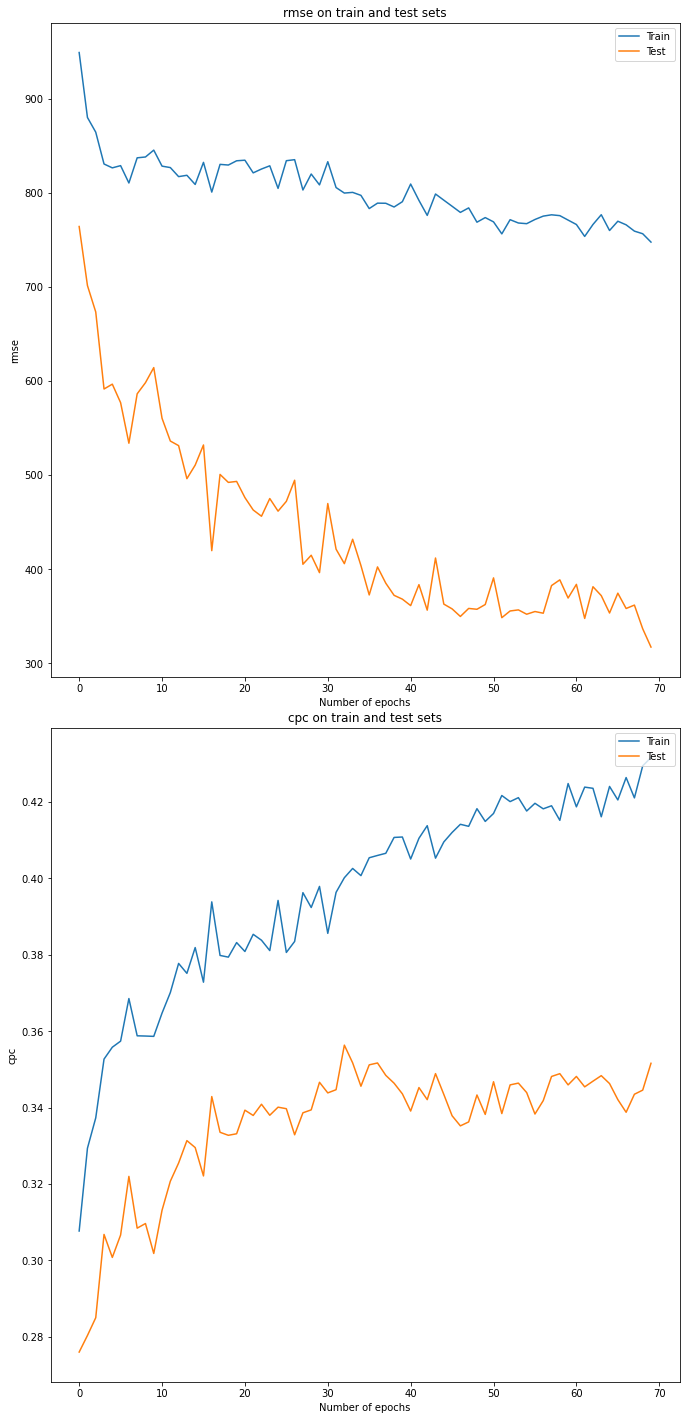

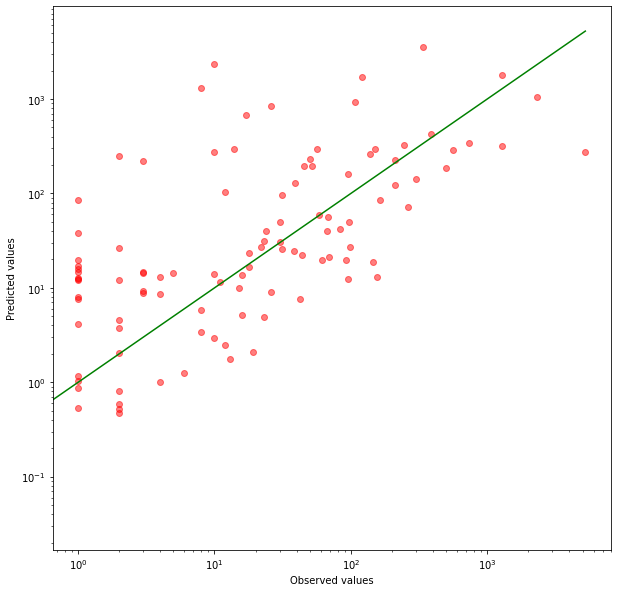

In [15]:

data = lstm_df_base
model = lstmModelReg(data,loss=cpc_loss,size_hidden_layer=70,dropout=0.2)
history_base_w = train_evaluate(model, data, test_month = np.datetime64('2020-11-01'), verbose = 1, epoch = 70)
display_training(history_base_w,name='base_with_weights')
dataResult = evaluateBySerie(model,lstm_df_base)
train_metrics,test_metrics,total_train_metrics,total_test_metrics = totalEvaluation(dataResult)

  ### 3.2.2 With GTI  <a id="3.2.2">

In [16]:
data = lstm_df_gti
model = lstmModelReg(data,loss=cpc_loss,size_hidden_layer=70,dropout=0.2)
history_gti_w = train_evaluate(model, data, test_month = np.datetime64('2020-11-01'), verbose = 1, epoch = 70)
display_training(history_gti_w,name='base_with_weights')
dataResult = evaluateBySerie(model,lstm_df_gti)
train_metrics,test_metrics,total_train_metrics,total_test_metrics = totalEvaluation(dataResult)


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 1
train rmse : 918.6198833702207 - train cpc : 0.313343282094303
test rmse : 715.8598346303828 - test cpc : 0.2873445923107899


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 2
train rmse : 900.4235495391614 - train cpc : 0.3250304910278229
test rmse : 710.7403220749446 - test cpc : 0.2857047349319371


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 3
train rmse : 848.4253249907531 - train cpc : 0.3470347255598092
test rmse : 564.6219759563581 - test cpc : 0.3109259687369279


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 4
train rmse : 822.9309342188466 - train cpc : 0.3645522368042551
test rmse : 471.75312197331505 - test cpc : 0.3215932810450979


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 5
train rmse : 823.6010115461845 - train cpc : 0.36664547377212137
test rmse : 485.02398329901115 - test cpc : 0.3213103731706845


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 6
train rmse : 805.7721469261985 - train cpc : 0.37687504718964077
test rmse : 444.70613767833083 - test cpc : 0.32568523110324293


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 7
train rmse : 816.7951617998363 - train cpc : 0.37443487079108956
test rmse : 474.8835645647497 - test cpc : 0.32261500497841433


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 8
train rmse : 811.359106379359 - train cpc : 0.3735973707012755
test rmse : 488.7469089012803 - test cpc : 0.32750991508084965


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 9
train rmse : 820.0633276611875 - train cpc : 0.3709156361179056
test rmse : 520.9299161322492 - test cpc : 0.31879354610918587


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 10
train rmse : 811.0738251673434 - train cpc : 0.3796649258994189
test rmse : 507.3235488623507 - test cpc : 0.3223955914751523


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 11
train rmse : 801.3399312271191 - train cpc : 0.38352179680500686
test rmse : 515.7751860568958 - test cpc : 0.32046170622809755


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 12
train rmse : 793.6394630593958 - train cpc : 0.38796940259580526
test rmse : 520.3096503285227 - test cpc : 0.31671803629461626


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 13
train rmse : 802.1827212223303 - train cpc : 0.38989413372835363
test rmse : 564.0791577273675 - test cpc : 0.3087616158507692


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 14
train rmse : 774.3192848952582 - train cpc : 0.39828108926164885
test rmse : 493.84997489860865 - test cpc : 0.32756180380859495


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 15
train rmse : 819.0041771819377 - train cpc : 0.3781275578267399
test rmse : 591.4534037558105 - test cpc : 0.30065214916284533


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 16
train rmse : 776.3411926083246 - train cpc : 0.3961008254711004
test rmse : 535.295900001488 - test cpc : 0.31580676535066926


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 17
train rmse : 783.3470294203764 - train cpc : 0.39619343191245393
test rmse : 545.3876234641917 - test cpc : 0.31644608517094813


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 18
train rmse : 767.1029933484134 - train cpc : 0.4021309560445722
test rmse : 511.207241017689 - test cpc : 0.3261658139325935


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 19
train rmse : 771.9251318706891 - train cpc : 0.4033739557203004
test rmse : 482.1513690733234 - test cpc : 0.33415708846188863


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 20
train rmse : 771.3500825111034 - train cpc : 0.403198531598583
test rmse : 466.1911839346153 - test cpc : 0.3374684500766099


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 21
train rmse : 782.6478156671095 - train cpc : 0.4027380738437251
test rmse : 490.1098743663605 - test cpc : 0.3322402369508264


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 22
train rmse : 751.3030147584254 - train cpc : 0.4150114955322305
test rmse : 412.3347473596885 - test cpc : 0.34029822573977553


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 23
train rmse : 752.9316160792083 - train cpc : 0.4133460677202293
test rmse : 402.8531962466756 - test cpc : 0.3352179255771999


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 24
train rmse : 774.5980125092361 - train cpc : 0.4019260547184032
test rmse : 429.8607622542878 - test cpc : 0.33943464761422115


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 25
train rmse : 767.6789928885349 - train cpc : 0.40504025558104334
test rmse : 463.7201125792465 - test cpc : 0.3393577859977557


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 26
train rmse : 766.7873752339472 - train cpc : 0.4084051497057947
test rmse : 464.3399697876684 - test cpc : 0.338310594350802


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 27
train rmse : 769.5914436915978 - train cpc : 0.409707442909882
test rmse : 447.2636110970807 - test cpc : 0.33948615813843647


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 28
train rmse : 761.1938590997457 - train cpc : 0.4109257122286065
test rmse : 429.4892876647879 - test cpc : 0.3440392005098725


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 29
train rmse : 752.739470827263 - train cpc : 0.4172257581889437
test rmse : 406.0728267836987 - test cpc : 0.3322121819225373


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 30
train rmse : 757.7818745530714 - train cpc : 0.41720350924151306
test rmse : 435.0167843621519 - test cpc : 0.3362999052708719


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 31
train rmse : 754.7002865586472 - train cpc : 0.4157625029396419
test rmse : 419.8579919332662 - test cpc : 0.3272979938872653


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 32
train rmse : 751.3880475501269 - train cpc : 0.4171171339639639
test rmse : 433.60151545939783 - test cpc : 0.3299272715283999


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 33
train rmse : 735.860579888293 - train cpc : 0.42286517519266503
test rmse : 407.78136195445654 - test cpc : 0.33780418798862016


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 34
train rmse : 769.8073266086259 - train cpc : 0.41556351863800683
test rmse : 430.04793592448186 - test cpc : 0.3293341170780166


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 35
train rmse : 767.7949515682689 - train cpc : 0.4117904455094208
test rmse : 459.89815960641715 - test cpc : 0.3229944220761993


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 36
train rmse : 753.1301291459965 - train cpc : 0.41872333581738486
test rmse : 413.6091782711419 - test cpc : 0.3292901268863359


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 37
train rmse : 743.3909435924913 - train cpc : 0.418995263410496
test rmse : 433.0281329589474 - test cpc : 0.3439881210678348


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 38
train rmse : 745.7716929573954 - train cpc : 0.42009116750555997
test rmse : 453.72715750539936 - test cpc : 0.34474321853396866


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 39
train rmse : 751.3783143783758 - train cpc : 0.41841413126439264
test rmse : 460.55933914658027 - test cpc : 0.3371285382234042


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 40
train rmse : 749.7710990010654 - train cpc : 0.4215816024230458
test rmse : 429.17306548909465 - test cpc : 0.3372343325261613


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 41
train rmse : 754.9451768968527 - train cpc : 0.41816527841555856
test rmse : 449.8599848371009 - test cpc : 0.3291054331378744


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 42
train rmse : 734.1992524871042 - train cpc : 0.42556125100368475
test rmse : 454.80441802561637 - test cpc : 0.33503763507339035


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 43
train rmse : 742.5811096955366 - train cpc : 0.42322267261490537
test rmse : 434.90853193481064 - test cpc : 0.3354520344644821


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 44
train rmse : 738.3923521091787 - train cpc : 0.42274114589086914
test rmse : 420.24103883854485 - test cpc : 0.340359145726396


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 45
train rmse : 742.1949196872656 - train cpc : 0.422907351252519
test rmse : 419.5885220223914 - test cpc : 0.33905627430129714


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 46
train rmse : 733.0667157616155 - train cpc : 0.42663558060170254
test rmse : 436.66281733812093 - test cpc : 0.3347302661259985


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 47
train rmse : 751.6395418424374 - train cpc : 0.42381632648534356
test rmse : 443.5584698019399 - test cpc : 0.33828881284206597


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 48
train rmse : 727.3087527584606 - train cpc : 0.4306392034099559
test rmse : 412.9943277707807 - test cpc : 0.33633469650482634


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 49
train rmse : 727.698652821228 - train cpc : 0.4283751962395899
test rmse : 391.2274633473109 - test cpc : 0.33336803219363137


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 50
train rmse : 734.3206395218599 - train cpc : 0.42924821625928333
test rmse : 411.4265241276649 - test cpc : 0.330718615971779


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 51
train rmse : 720.6242628616445 - train cpc : 0.43381126715055857
test rmse : 368.4130063802569 - test cpc : 0.34061603145759983


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 52
train rmse : 724.2744016485922 - train cpc : 0.43541917389670864
test rmse : 394.42456370338294 - test cpc : 0.3423000901733161


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 53
train rmse : 740.2360751410617 - train cpc : 0.431317138902057
test rmse : 406.8646655275927 - test cpc : 0.3368577408367251


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 54
train rmse : 756.4710347207714 - train cpc : 0.4259639290093507
test rmse : 439.01849365846294 - test cpc : 0.32928760080298447


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 55
train rmse : 730.4067246214223 - train cpc : 0.42838269021852904
test rmse : 403.4240533411946 - test cpc : 0.33203813257687975


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 56
train rmse : 751.1833881509226 - train cpc : 0.42490424487785694
test rmse : 428.0216986523007 - test cpc : 0.3337774835977208


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 57
train rmse : 745.458896029373 - train cpc : 0.4262539748641505
test rmse : 426.66408645320837 - test cpc : 0.33438486322792765


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 58
train rmse : 750.9736224403505 - train cpc : 0.42369012129236866
test rmse : 427.16965942983086 - test cpc : 0.3411171093286765


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 59
train rmse : 699.9610417289821 - train cpc : 0.4374622450779927
test rmse : 362.3141059981914 - test cpc : 0.3377141313970267


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 60
train rmse : 716.6565269784406 - train cpc : 0.43696732586589254
test rmse : 392.74858145871644 - test cpc : 0.338456169714915


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 61
train rmse : 745.1748389927051 - train cpc : 0.42802252855267114
test rmse : 455.9580403529694 - test cpc : 0.3314939946048826


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 62
train rmse : 719.1692181785769 - train cpc : 0.4330755777247113
test rmse : 410.6894056959615 - test cpc : 0.33314114150283386


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 63
train rmse : 737.102845805215 - train cpc : 0.43083923678036656
test rmse : 400.0933084964866 - test cpc : 0.3295276272963536


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 64
train rmse : 735.5724311908352 - train cpc : 0.4323285720518326
test rmse : 381.60512571812046 - test cpc : 0.32751514601135606


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 65
train rmse : 714.4542620921508 - train cpc : 0.436924350699594
test rmse : 415.8537089745349 - test cpc : 0.34309166275440417


KeyboardInterrupt: 

## 3.3 Comparing the RMSE of naked FE model to the model including GTI  <a id="3.3">
## Comparing the naked FE model to the 

In [ ]:
plt.plot(history_gti_now[4], label="With GTI")
plt.plot(history_base_now[4], label="Without GTI")
plt.legend(loc="upper right")

In [14]:
data = lstm_df_gti
model = lstmModel(data,loss=cpc_loss,size_hidden_layer=70,dropout=0.2)
history_gti_now = train_evaluate(model, data, test_month = np.datetime64('2020-07-01'), verbose = 1, epoch = 100)
display_training(history_gti_now,name='gti_no_weights')
dataResult = evaluateBySerie(model,lstm_df_gti)
train_metrics,test_metrics,total_train_metrics,total_test_metrics = totalEvaluation(dataResult)

<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 1
train rmse : 901.2128791243961 - train cpc : 0.317900001932265
test rmse : 821.4911683374388 - test cpc : 0.2673735305060437


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 2
train rmse : 846.9309502276136 - train cpc : 0.34658667615915034
test rmse : 694.2965955999604 - test cpc : 0.287904115987035


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 3
train rmse : 838.9408803648874 - train cpc : 0.35081154675909826
test rmse : 639.595008914659 - test cpc : 0.29943387631631546


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 4
train rmse : 840.4969176281369 - train cpc : 0.355204381268992
test rmse : 629.0813559426479 - test cpc : 0.30067942457003294


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 5
train rmse : 825.5473951869715 - train cpc : 0.3651203308061709
test rmse : 588.2683722971968 - test cpc : 0.31505888208962085


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 6
train rmse : 810.5221536309016 - train cpc : 0.3759584389380046
test rmse : 558.588837227592 - test cpc : 0.3171275588447595


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 7
train rmse : 798.280377292623 - train cpc : 0.3870342691614816
test rmse : 453.0929606258482 - test cpc : 0.33594692773576834


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 8
train rmse : 819.294782226959 - train cpc : 0.3840548542622069
test rmse : 431.7104893257657 - test cpc : 0.33182535832125626


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 9
train rmse : 846.4176758050196 - train cpc : 0.3742527661448981
test rmse : 500.4338542685327 - test cpc : 0.3214763029549927


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 10
train rmse : 802.5627236617042 - train cpc : 0.39330530663400354
test rmse : 439.1616044978444 - test cpc : 0.33132408574509026


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 11
train rmse : 817.5525814062933 - train cpc : 0.38747000370755547
test rmse : 469.53560044081473 - test cpc : 0.3316048715212418


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 12
train rmse : 812.7933139578663 - train cpc : 0.3885355723649398
test rmse : 470.66397785872954 - test cpc : 0.3312805305956419


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 13
train rmse : 825.0699056318283 - train cpc : 0.38566920600003185
test rmse : 499.7998407864081 - test cpc : 0.3287525805360372


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 14
train rmse : 802.9871650788242 - train cpc : 0.3953878673095048
test rmse : 428.6751809022598 - test cpc : 0.3248668131087334


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 15
train rmse : 825.4237493069367 - train cpc : 0.38480236308220744
test rmse : 431.27157079082326 - test cpc : 0.3338476792797939


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 16
train rmse : 813.7693812138925 - train cpc : 0.3933901204514212
test rmse : 405.9629265162032 - test cpc : 0.33094379183725675


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 17
train rmse : 810.65404456117 - train cpc : 0.39289605527164767
test rmse : 411.01927455552294 - test cpc : 0.3280089689273005


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 18
train rmse : 801.3164318857528 - train cpc : 0.3976893546334965
test rmse : 398.94202529615694 - test cpc : 0.3315420807279801


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 19
train rmse : 802.2316189103313 - train cpc : 0.3978851598081616
test rmse : 405.21430490076517 - test cpc : 0.32633161305518216


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 20
train rmse : 823.4078162222607 - train cpc : 0.389505958008453
test rmse : 408.4100170733468 - test cpc : 0.3246776523882594


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 21
train rmse : 827.4203266661794 - train cpc : 0.38585318273516966
test rmse : 435.2120621809089 - test cpc : 0.3292789286764762


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 22
train rmse : 823.1242008545258 - train cpc : 0.38953849305438937
test rmse : 428.09617057861175 - test cpc : 0.32347249261791616


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 23
train rmse : 789.5834667796065 - train cpc : 0.4012803690474942
test rmse : 374.0021616387636 - test cpc : 0.33716603554162855


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 24
train rmse : 809.5708308859548 - train cpc : 0.3953223070768762
test rmse : 390.72456352049085 - test cpc : 0.3302053941998687


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 25
train rmse : 834.8311461236306 - train cpc : 0.3921873742926682
test rmse : 393.2480862902647 - test cpc : 0.3358900989036357


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 26
train rmse : 794.4244576225245 - train cpc : 0.4042308274974736
test rmse : 342.06716474435933 - test cpc : 0.3261415279117118


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 27
train rmse : 806.4840080944767 - train cpc : 0.4020870549157143
test rmse : 349.70540215355686 - test cpc : 0.33054581807929984


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 28
train rmse : 810.1893550624831 - train cpc : 0.39972029235161677
test rmse : 345.76228137596047 - test cpc : 0.3311441587801066


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 29
train rmse : 817.0096157111235 - train cpc : 0.3967811422229562
test rmse : 377.37360222968624 - test cpc : 0.3272256355619378


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 30
train rmse : 828.9686300016897 - train cpc : 0.3925343653891697
test rmse : 401.14628438930237 - test cpc : 0.3382594029185072


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 31
train rmse : 846.2585766539173 - train cpc : 0.38922435843588465
test rmse : 419.89716129587896 - test cpc : 0.33773624314443806


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 32
train rmse : 804.81898808657 - train cpc : 0.40375091014047476
test rmse : 345.72750440645177 - test cpc : 0.32942299523930285


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 33
train rmse : 824.7213273735842 - train cpc : 0.3982862972128868
test rmse : 422.81660974443747 - test cpc : 0.3326864727312201


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 34
train rmse : 806.723813499905 - train cpc : 0.4054309659434046
test rmse : 363.7795717225302 - test cpc : 0.3361970132943067


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 35
train rmse : 801.2324390397443 - train cpc : 0.40859955548402627
test rmse : 343.81815800581666 - test cpc : 0.33622134795987957


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 36
train rmse : 809.8685178907747 - train cpc : 0.4061350270440825
test rmse : 345.42852841284815 - test cpc : 0.3320693160363714


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 37
train rmse : 868.0700207539013 - train cpc : 0.39193057565754474
test rmse : 436.8317034257685 - test cpc : 0.3314842612722159


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 38
train rmse : 809.4994435280202 - train cpc : 0.4042584384575133
test rmse : 393.1542666835559 - test cpc : 0.33333584686653156


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 39
train rmse : 779.5246591581808 - train cpc : 0.4126884782897944
test rmse : 371.0619681887916 - test cpc : 0.33976707333265876


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 40
train rmse : 788.2968449928919 - train cpc : 0.4188798531364432
test rmse : 318.9303606008263 - test cpc : 0.3449025790228791


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 41
train rmse : 802.8154166073253 - train cpc : 0.4077119828281203
test rmse : 356.6329060072512 - test cpc : 0.34401069067166784


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 42
train rmse : 788.7228151403436 - train cpc : 0.4182275575884204
test rmse : 400.77858295586884 - test cpc : 0.34700879212733016


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 43
train rmse : 795.0956043821081 - train cpc : 0.4146392054536777
test rmse : 400.11800701356134 - test cpc : 0.34105548218655324


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 44
train rmse : 807.5470347785122 - train cpc : 0.4116721922479124
test rmse : 385.772961211127 - test cpc : 0.3365836936161287


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 45
train rmse : 764.047439397489 - train cpc : 0.4215095036700739
test rmse : 317.06427696520706 - test cpc : 0.35033116150870236


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 46
train rmse : 797.186732352162 - train cpc : 0.41287834716744587
test rmse : 338.8077594919508 - test cpc : 0.3397036995963544


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 47
train rmse : 832.7286130357902 - train cpc : 0.4026804733355152
test rmse : 382.29316793743175 - test cpc : 0.3378600139452924


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 48
train rmse : 778.3977777229261 - train cpc : 0.42420037403611516
test rmse : 335.2241733910904 - test cpc : 0.34396171255018004


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 49
train rmse : 807.7831908871764 - train cpc : 0.4147096987806021
test rmse : 362.32442145409976 - test cpc : 0.344417697569001


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 50
train rmse : 825.050798034497 - train cpc : 0.41029783709834333
test rmse : 392.1875786808041 - test cpc : 0.33920307368665


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 51
train rmse : 791.0568687402916 - train cpc : 0.4189294449933632
test rmse : 359.3578289384751 - test cpc : 0.3367521293218558


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 52
train rmse : 798.3639738074621 - train cpc : 0.4160983922127268
test rmse : 358.32257049611155 - test cpc : 0.3377472094848214


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 53
train rmse : 804.9270836907074 - train cpc : 0.4170723510881887
test rmse : 456.09881715417265 - test cpc : 0.3390088242101817


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 54
train rmse : 804.7828419970016 - train cpc : 0.4134513959288909
test rmse : 367.0721272717433 - test cpc : 0.3404570214108123


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 55
train rmse : 782.2000495557754 - train cpc : 0.42277791415171895
test rmse : 344.7329748016121 - test cpc : 0.3464382053699371


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 56
train rmse : 797.003321761253 - train cpc : 0.41472447666158146
test rmse : 350.1193906360693 - test cpc : 0.31982224606150156


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 57
train rmse : 800.8673222024847 - train cpc : 0.4221110543648029
test rmse : 412.7427402644211 - test cpc : 0.3386053479484096


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 58
train rmse : 762.6451197112883 - train cpc : 0.4270569920174336
test rmse : 339.3176062157694 - test cpc : 0.33979967014773427


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 59
train rmse : 785.8878996604794 - train cpc : 0.42112878717091623
test rmse : 385.5060641104485 - test cpc : 0.3413888019177362


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 60
train rmse : 807.3703974140997 - train cpc : 0.41575928841403037
test rmse : 431.47732194730725 - test cpc : 0.33806061973564827


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 61
train rmse : 763.161545395382 - train cpc : 0.42995041387473876
test rmse : 344.9303513605325 - test cpc : 0.34307302331099104


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 62
train rmse : 773.004298843763 - train cpc : 0.42926081401271804
test rmse : 348.46723514469124 - test cpc : 0.3383062798157424


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 63
train rmse : 797.6076562595301 - train cpc : 0.4189730013784107
test rmse : 343.24002669695756 - test cpc : 0.32538109170723956


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 64
train rmse : 798.4273221168777 - train cpc : 0.41427303606556365
test rmse : 404.3273915361447 - test cpc : 0.3397514210432656


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 65
train rmse : 788.8882396306594 - train cpc : 0.4238776355939725
test rmse : 356.52103115004957 - test cpc : 0.33698353383019886


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 66
train rmse : 777.1971069991691 - train cpc : 0.425617802377257
test rmse : 342.238338055211 - test cpc : 0.34019563998532487


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 67
train rmse : 759.3740555886247 - train cpc : 0.43468319112016285
test rmse : 304.4071205325141 - test cpc : 0.33296448051993044


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 68
train rmse : 788.851907565835 - train cpc : 0.42187843866340935
test rmse : 357.5577583591699 - test cpc : 0.3439578461560422


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 69
train rmse : 777.2059942645592 - train cpc : 0.42877977566923114
test rmse : 346.91132670778717 - test cpc : 0.3239091894582316


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 70
train rmse : 774.0943825522019 - train cpc : 0.4263660384005639
test rmse : 339.2648614424478 - test cpc : 0.3474297988724796


<ipython-input-10-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 71
train rmse : 788.6362299331764 - train cpc : 0.42257157005273854
test rmse : 423.54556651663313 - test cpc : 0.34975620000763996


KeyboardInterrupt: 

In [ ]:
data = lstm_df_gti
model = lstmModelReg(data,loss=cpc_loss,size_hidden_layer=70,dropout=0.2)
history_gti_now = train_evaluate(model, data, test_month = np.datetime64('2020-07-01'), verbose = 1, epoch = 100)
display_training(history_gti_now,name='gti_no_weights')
dataResult = evaluateBySerie(model,lstm_df_gti)
train_metrics,test_metrics,total_train_metrics,total_test_metrics = totalEvaluation(dataResult)